In [0]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import xml.etree.ElementTree as ET

In [0]:
TARGET_RES = 380 # 19x20

In [0]:
def warp_to_gray_and_equalize(img, rect):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    assert (rows >= TARGET_RES and cols >= TARGET_RES), "input res too low"
    target_corners = np.float32([[0, 0], [TARGET_RES, 0],
                                [TARGET_RES, TARGET_RES], [0, TARGET_RES]])
    M = cv2.getPerspectiveTransform(rect, target_corners)
    
    #actual transform, result is already cropped by process:
    warped = cv2.warpPerspective(gray, M, (TARGET_RES, TARGET_RES))
    #adaptive histogram equalization:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return warped

In [0]:
def warp_labeled():
    for file in os.listdir('./images/'):
        #print(file)
        img = cv2.imread('./images/'+file)
        points = {}
        tree = ET.parse('labels/'+file.rstrip('png')+'xml')
        root = tree.getroot()
        for obj in root.findall('object'):
            tag = obj.find('name').text
            x = obj.find('point').find('x1').text
            y = obj.find('point').find('y1').text
            points[tag] = [x,y]
        rect = np.float32([points['ul_board_corner'],points['dl_board_corner'],
                    points['dr_board_corner'],points['ur_board_corner']])
        warped = warp_to_gray_and_equalize(img,rect)
        cv2.imwrite('./warped/w_'+file, warped)


In [0]:
def cut_segments(img):
    size = TARGET_RES // 19
    result = []
    for x in range(19):
        for y in range(19):
            segment = img[x*size:(x+1)*size, y*size:(y+1)*size]
            result.append(segment)
    return result

In [0]:
def batch_segment():
    for file in os.listdir('./warped_for_segmentation/'):
        img = cv2.imread('./warped_for_segmentation/'+file, cv2.IMREAD_GRAYSCALE)
        segments = cut_segments(img)
        for i, segment in enumerate(segments):
            cv2.imwrite('./segments/'+str(i)+'_'+file, segment)

361
(20, 20)


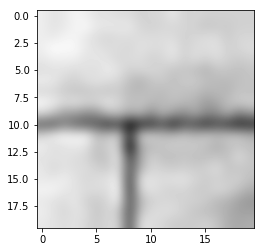

In [0]:
#test segmentation
img = cv2.imread('./warped/w_IMG_0707.png', cv2.IMREAD_GRAYSCALE)
segments = cut_segments(img)
print(len(segments))
sample = segments[6]
print(sample.shape)
plt.imshow(sample, cmap = 'gray', interpolation = 'bicubic')
plt.show()